# Aim
- to predict the Price of NYC real-state using data retrieved from this [link](https://www.kaggle.com/new-york-city/nyc-property-sales)

Notes:
- need to pre-process data
- need to do feature selection for price modeling
- try to apply Regression model to predict the price (Bayesian Linear Regression)

In [167]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline

# EDA

## Data Preprocessing

In [140]:
#read in the file
df = pd.read_csv('*/nyc_rolling_sales.csv')

#drop the irrelavant column named 'Unnamed: 0'
df.drop(columns = 'Unnamed: 0', inplace = True)

#need to rename the columns replacing space and dash in the column name with underscore
df.columns = [x.replace(" ","_").replace("-", "_") for x in df.columns]

#add a column for the age of the building
df['AGE'] = df['YEAR_BUILT'].apply(lambda x: 2020-x)

#drop the "YEAR_BUILT" column
df.drop(columns = 'YEAR_BUILT', inplace = True)



In [141]:
######################################
#Invalid/Missing Data May be in dataset
#######################################
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING_CLASS_CATEGORY         84548 non-null  object
 3   TAX_CLASS_AT_PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE_MENT                       84548 non-null  object
 7   BUILDING_CLASS_AT_PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT_NUMBER                84548 non-null  object
 10  ZIP_CODE                        84548 non-null  int64 
 11  RESIDENTIAL_UNITS               84548 non-null  int64 
 12  COMMERCIAL_UNITS                84548 non-null

In [142]:
print(df['SALE_PRICE'].unique())

['6625000' ' -  ' '3936272' ... '408092' '11693337' '69300']


In [143]:
#dealing with missing values in the data by replacing "-" and " -  " with nan
missing_value = ["-",' -  ']
df.replace(missing_value, np.nan, inplace=True)

#counting the number of nulls
print(df.isnull().sum())
print(df.isnull().sum().sum())

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  0
BLOCK                                 0
LOT                                   0
EASE_MENT                             0
BUILDING_CLASS_AT_PRESENT             0
ADDRESS                               0
APARTMENT_NUMBER                      0
ZIP_CODE                              0
RESIDENTIAL_UNITS                     0
COMMERCIAL_UNITS                      0
TOTAL_UNITS                           0
LAND_SQUARE_FEET                  26252
GROSS_SQUARE_FEET                 27612
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                        14561
SALE_DATE                             0
AGE                                   0
dtype: int64
68425


In [144]:
#drop rows where the sale price,LAND SQUARE FEET,GROSS SQUARE FEET  is null
col = ["SALE_PRICE","LAND_SQUARE_FEET","GROSS_SQUARE_FEET"]
df.dropna(subset=col, inplace = True)

#has over 48k data to work with, still good enough
print(len(df))

#turn those 3 attribute into int type
for x in col:
    df[x] = df[x].astype(int)

48244


In [145]:
#sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48244 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         48244 non-null  int64 
 1   NEIGHBORHOOD                    48244 non-null  object
 2   BUILDING_CLASS_CATEGORY         48244 non-null  object
 3   TAX_CLASS_AT_PRESENT            48244 non-null  object
 4   BLOCK                           48244 non-null  int64 
 5   LOT                             48244 non-null  int64 
 6   EASE_MENT                       48244 non-null  object
 7   BUILDING_CLASS_AT_PRESENT       48244 non-null  object
 8   ADDRESS                         48244 non-null  object
 9   APARTMENT_NUMBER                48244 non-null  object
 10  ZIP_CODE                        48244 non-null  int64 
 11  RESIDENTIAL_UNITS               48244 non-null  int64 
 12  COMMERCIAL_UNITS                48244 non-null

## Standardization 
- do standardization on continuous variables with the goal of minimize variance

In [401]:
from sklearn.preprocessing import StandardScaler

#define the categorical attribute and the dependent attribute that I dont want to do PCA on
categ_att = ["BOROUGH","ZIP_CODE",'TAX_CLASS_AT_TIME_OF_SALE']


#Get a list column names for which its value type in int64, exclude categorical attributes
cont_att = [x for x in df.columns if df[x].dtype == int and x not in categ_att]
df_std = df.loc[:,cont_att]


#put the standardized data back into the dataframe 
scaler = StandardScaler()
standardized_values = scaler.fit_transform(df_std)
df_std = pd.DataFrame(data =standardized_values,
                      columns = cont_att,index = None
                     )
                      
#sanity check
df_std.head(2)

,BLOCK,LOT,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,SALE_PRICE,AGE
0,-1.339953,-0.460001,0.139331,-0.022677,0.104354,-0.054878,0.093988,0.408302,-0.155559
1,-1.337036,-0.429781,0.425613,-0.022677,0.345316,-0.034551,0.105998,0.207668,-0.183555


## Dimension Reduction (PCA)
- do the PCA on these numerical variables, excluding the dependent variable (Y) of `SALE_PRICE`

**findings**:
- seems like 4 component explained ~80% of total variance

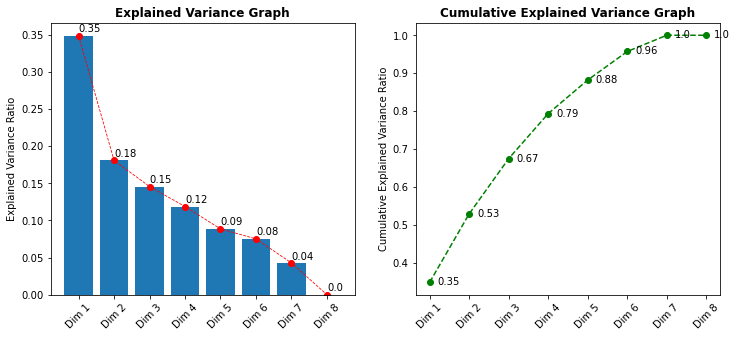

,BLOCK,LOT,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,AGE
0,0.217672,0.044890,-0.045695,-1.373512,0.03996,-0.366352,-0.010389,-0.000031
1,0.509740,0.062364,-0.016097,-1.378124,-0.16630,-0.337242,-0.121681,-0.000001


In [408]:
from sklearn.decomposition import PCA

#intantiate the reducer
reducer = PCA(random_state =3)

#fit and transform the data on itself, exclude the dependent variable (sales price) when doing PCA
reduce_data = reducer.fit_transform(df_std.drop("SALE_PRICE", axis = 1, inplace = False))

#put it as a dataframe
df_reduced = pd.DataFrame(data = reduce_data,
                          columns = (df_std.drop("SALE_PRICE", axis = 1, inplace = False).columns),
                          index = None
                         )

#explained variance ratio
variance_ratio = reducer.explained_variance_ratio_
variance_ratio_sum = reducer.explained_variance_ratio_.cumsum()

#plot 
fig, ax = plt.subplots(ncols=2, figsize = (12,5))
x_labels = ["Dim %s"%x.astype(int) for x in np.linspace(1,len(df_reduced.columns),len(df_reduced.columns))]

#plot the Explained Variance Graph graph 
ax[0].bar(x = x_labels, height = variance_ratio)# - bar
ax[0].plot(x_labels,variance_ratio, color = 'r', linestyle = "--",marker="o", linewidth = 0.8) #-line
ax[0].set_xticklabels(x_labels,rotation=45);
ax[0].set_title("Explained Variance Graph", fontweight = "bold");
ax[0].set_ylabel("Explained Variance Ratio");
#annotate the points
for x,y in zip(np.linspace(1,9,9), variance_ratio):
    num = str(np.round(y, decimals =2))
    ax[0].annotate(num, xy = (x-1,y+0.005))



#plot the cumulative  Explained Variance Graph graph
ax[1].plot(x_labels,variance_ratio_sum, color = "green", linestyle = "--",marker="o");
ax[1].set_xticklabels(x_labels,rotation = 45);
ax[1].set_title("Cumulative Explained Variance Graph", fontweight = "bold");
ax[1].set_ylabel("Cumulative Explained Variance Ratio");
#annotate the points
for x,y in zip(np.linspace(1,9,9), variance_ratio_sum):
    num = str(np.round(y, decimals =2))
    ax[1].annotate(num, xy = (x-0.8,y-0.007))
    

plt.show()
df_reduced.head(2)

## Feature Selection - RFE

In [392]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#instaniate RFE to select 4 features of imprtance
rfe = RFE(estimator = LinearRegression(),
          n_features_to_select = 4,
          verbose = 1)

#fit on the data, X = all the 8 dimension, Y = the sale price
rfe.fit(df_reduced, df['SALE_PRICE']);

#assess the important features
cols_important_mask = rfe.support_
print("The final %s selected features of importance are: %s" %(rfe.n_features_,df_reduced.columns[rfe.support_].values))




Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
The final 4 selected features of importance are: ['BLOCK' 'RESIDENTIAL_UNITS' 'GROSS_SQUARE_FEET' 'AGE']


# Bayesian Linear Regression
**Notes**
- SALE_PRICE ~ BLOCK + RESIDENTIAL_UNITS + GROSS_SQUARE_FEET + AGE
- Must standardize the data before fitting it into the model for it to converge since the values are too large

**Bayes Theorem**: to get $\beta$ at given X(input) and q(obtained output) to fit on new data

$$P(\beta|q,X) = \Large\frac{P(q|\beta,X)\times P(\beta|X)}{\int P(q, X|\beta_i)\mathrm{d\beta_i}}$$

where:
- $P(\beta|q,X)$ = the posterior 
- $P(q|\beta,X)$ = the likelihood of data
- $P(\beta|X)$ = the prior probability of parameters
- $\int P(q, X|\beta_i)\mathrm{d\beta_i}$ = the marginal probability




**Markov Chain Monte Carlo using the pymc3 model**
- Markov Chain Monte Carlo: used to approximate the posterior without computing the marginal lielihood
- Monte Carlo: the general technique of drawing random samples
- Markov Chain: means the next sample is drawn based on the value of prior sample

_(Note: the pymc3 model takes a dataframe, need to also include the Target variable (y) in the X_train and X_test)_


## Train and Test sets split
- for the pymc3 model, the X train and X test must also contain the target variable

In [528]:
from sklearn.model_selection import train_test_split

##################
#split the training data
#Note::
#the X_train and X_test contains the target variable "SALE PRICE"
##################
dataframe_include_target_variable = pd.DataFrame(
    data = np.append(df_reduced.loc[:,cols_important_mask].values,df_std['SALE_PRICE'].values.reshape(-1,1), axis =1),
    columns = np.append(df_reduced.columns[cols_important_mask].values, "SALE_PRICE")
            )

X_train,X_test,y_train,y_test = train_test_split(dataframe_include_target_variable,
                                                  df_std['SALE_PRICE'],
                                                  test_size = 0.25,
                                                  random_state =3
                                                 )

## Build a Bayesian Linear Regression using pymc3
- The results are illustrated as posterior histograms for β_0, β_1, β_2, β_3, β_4 and σ. The histograms show 94% Highest Posterior Density (HPD).

In [529]:
import pymc3 as pm
from pymc3 import traceplot

#import warnings; warnings.simplefilter('ignore')

# Formula for Bayesian Linear Regression
formula = "SALE_PRICE ~ " + " + ".join(["%s" %variable for variable in X_train.columns if variable != "SALE_PRICE"])
print(formula)

# model specifications in PyMC3 are wrapped in a with-statement
with pm.Model() as linear_models:
    
    #the prior for the model parameters will be obtained from a normal distribution
    family = pm.glm.families.Normal()#it is Base class for Family of likelihood distribution and link functions
    
    #create the model using the formula above and the training data
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    #perform Markov Chain Monte Carlo Sampling
    normal_trace = pm.sample(draws=2000, cores = 2, tune = 500) #drawing 2000 samples, using 2 cores, failed because the values are too large, need to standardize them

SALE_PRICE ~ BLOCK + RESIDENTIAL_UNITS + GROSS_SQUARE_FEET + AGE


/Users/zhiying/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, AGE, GROSS_SQUARE_FEET, RESIDENTIAL_UNITS, BLOCK, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 34 seconds.


In [530]:
#get the summary of the bayesian model
pm.summary(normal_trace)

/Users/zhiying/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.001,0.005,-0.007,0.011,0.000,0.000,4425.0,2048.0,4458.0,3446.0,1.0
BLOCK,0.138,0.003,0.133,0.143,0.000,0.000,6643.0,6626.0,6659.0,3219.0,1.0
RESIDENTIAL_UNITS,-0.077,0.004,-0.084,-0.070,0.000,0.000,5394.0,5394.0,5401.0,3205.0,1.0
GROSS_SQUARE_FEET,0.955,0.008,0.940,0.969,0.000,0.000,6246.0,6246.0,6259.0,3429.0,1.0
AGE,0.862,0.952,-0.859,2.690,0.011,0.011,7164.0,3810.0,7245.0,3264.0,1.0
sd,0.899,0.003,0.892,0.905,0.000,0.000,6977.0,6977.0,6954.0,3222.0,1.0


/Users/zhiying/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


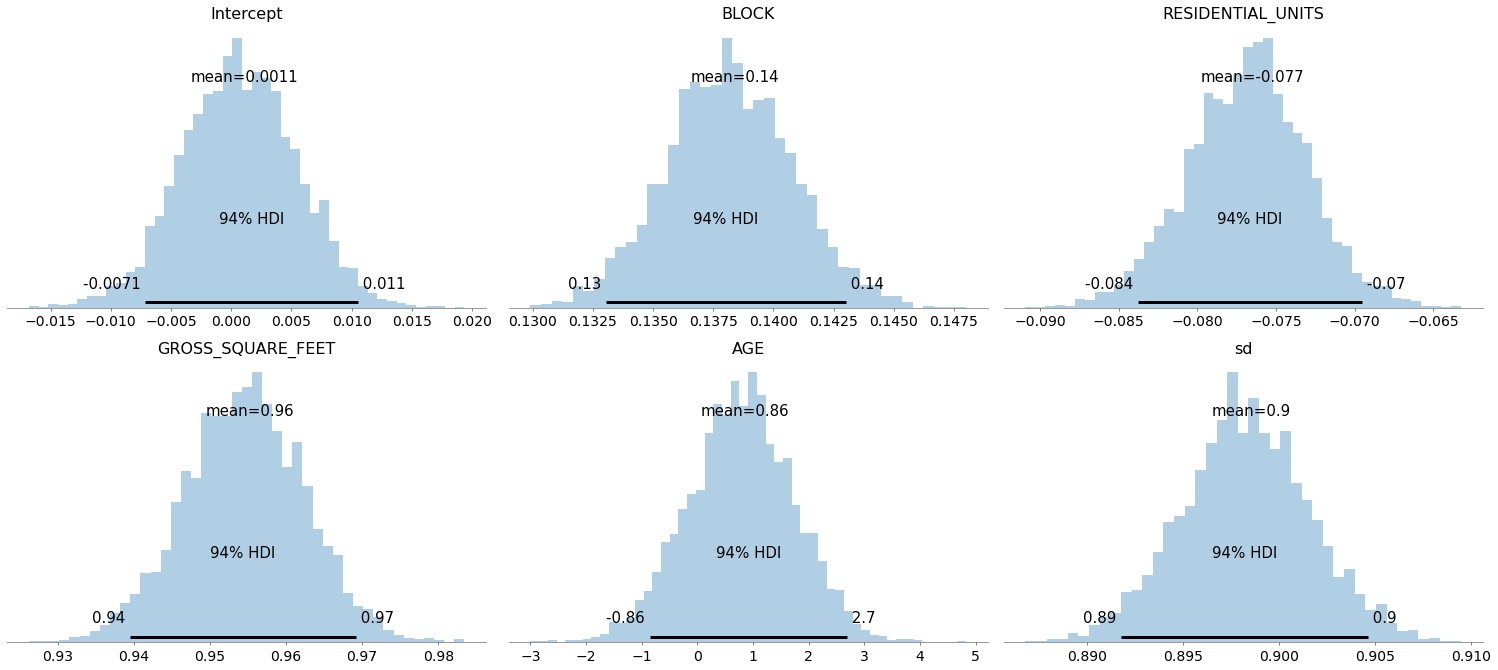

In [531]:
#plot the posterior distribution
pm.plots.plot_posterior(normal_trace, kind = 'hist');
plt.show()

## Evaluate the model using MAE and RMSE

**Metrics for Model**

- `Mean Absolute Error (MAE)`: The absolute value of the difference between predicted value and the actual value

$$MAE = \Large \frac{\sum |\hat y_i - y_i|}{n}$$


- `Root Mean Square Error (RMSE)`: the square root of the average of the square differences between the predictions and the actual values

$$RMSE = \Large \sqrt \frac{\sum \hat y - y_i^2}{n}$$

**To calculate the MAE, and RMSE:**
- take the median of the probability distribution for SALE_PRICE as the predicted value
- the true is the X_test['SALE_PRICE']
- then give it as the prediction to evaluate_prediction function.

**findings:**
The assessment of model performance shows that the predictor model has good accuracy.

In [532]:
# Define a function to calculate Mean Absolute Error (MAE) and Root Mean Square Error (RMSE)
def evaluate_prediction(prediction, true):
    mae = np.mean(abs(prediction - true))
    rmse = np.sqrt(np.mean((prediction - true) ** 2))
    return mae, rmse

median_pred = X_train['SALE_PRICE'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['SALE_PRICE']


# # Display mae and rmse
mae, rmse = evaluate_prediction(median_preds, true)
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))

Mean Absolute Error: 0.0700
Root Mean Square Error: 0.6189
